# Starbucks Promotional Response Prediction Using Machine Learning

This notebook implements the full end-to-end pipeline described in the Capstone project proposal:

1. Dynamically read AWS SageMaker configuration (execution role, default S3 bucket)  
2. Upload raw Starbucks JSON data from the project folder to S3  
3. Load raw data from S3 into a SageMaker notebook  
4. Clean and engineer features for:
   - Customer demographics (`profile.json`)
   - Offer metadata (`portfolio.json`)
   - Event logs (`transcript.json`)
5. Construct offer instances and label *true* offer responses  
6. Perform exploratory data analysis (EDA) to understand response patterns  
7. Split the labeled dataset into train, validation, and test sets  
8. Save processed datasets to S3  
9. Train baseline and advanced ML models to predict offer responsiveness  
10. Evaluate models using ROC-AUC, precision, recall, and F1  
11. Save the best model artifact to S3  
12. Run example inferences and interpret the outcome for marketing decisions  

The dataset is simulated, designed to reflect realistic behavioral patterns (not real individuals). 


## 1. Setup: SageMaker Session, Execution Role, and S3 Bucket

We begin by initializing the SageMaker session and retrieving:

- The **execution role** used by this notebook  
- The **default SageMaker S3 bucket**, which we will use to store:
  - Raw data
  - Processed labeled data
  - Model artifacts

Using these programmatic values avoids hard-coding AWS configuration.

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import io
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="deep")

# SageMaker session and role
session = sagemaker.Session()
role = sagemaker.get_execution_role()
print("Execution role:", role)

# Default S3 bucket
bucket = session.default_bucket()
print("Default bucket:", bucket)

# S3 prefixes for this project
raw_prefix = "starbucks/data"
model_prefix = "starbucks/model"   # model artifacts

s3 = boto3.client("s3")


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Execution role: arn:aws:iam::135432667076:role/service-role/AmazonSageMaker-ExecutionRole-20251117T145438
Default bucket: sagemaker-us-east-1-135432667076


## 2. Upload Raw Data to S3

The GitHub repository contains the raw files under `data/`:

- `portfolio.json`
- `profile.json`
- `transcript.json`

To make these files available to SageMaker jobs and future pipelines, we upload them to the default S3 bucket under the prefix:

`s3://<default-bucket>/starbucks/data/`


In [2]:
local_data_dir = "data"

for root, dirs, files in os.walk(local_data_dir):
    for file in files:
        if not file.endswith(".json"):
            continue
        local_file_path = os.path.join(root, file)
        s3_key = f"{raw_prefix}/{file}"
        s3.upload_file(local_file_path, bucket, s3_key)
        print(f"Uploaded {local_file_path} to s3://{bucket}/{s3_key}")


Uploaded data/portfolio.json to s3://sagemaker-us-east-1-135432667076/starbucks/data/portfolio.json
Uploaded data/profile.json to s3://sagemaker-us-east-1-135432667076/starbucks/data/profile.json
Uploaded data/transcript.json to s3://sagemaker-us-east-1-135432667076/starbucks/data/transcript.json


## 3. Load Raw Data from S3

Defind a helper function to load JSON files directly from S3 into pandas DataFrames.
We then load:

- `portfolio.json` — promotional offer metadata  
- `profile.json`   — customer demographics  
- `transcript.json` — event logs  


In [4]:
def read_json_from_s3(key: str) -> pd.DataFrame:
    """Read a JSON file from S3 (under raw_prefix) into a DataFrame."""
    obj = s3.get_object(Bucket=bucket, Key=f"{raw_prefix}/{key}")
    return pd.read_json(io.BytesIO(obj["Body"].read()), orient="records", lines=True)

portfolio = read_json_from_s3("portfolio.json")
profile   = read_json_from_s3("profile.json")
transcript = read_json_from_s3("transcript.json")


In [5]:
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [8]:
portfolio.info()
profile.info()
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
<class 'pandas.core.fra

## 4. Clean and Enrich Customer Profile Data

The customer `profile` table contains age, gender, income, and account creation date.  
We clean and enrich it by:

- Replacing age = 118 with missing (NaN)  
- Converting `became_member_on` to a proper datetime  
- Creating a `member_days` feature representing customer tenure  
- Renaming `id` to `person` to match the transcript data  


In [10]:
profile_df = profile.copy()

# Replace invalid age
profile_df["age"] = profile_df["age"].replace(118, np.nan)

# Convert membership date
profile_df["became_member_on"] = pd.to_datetime(
    profile_df["became_member_on"], format="%Y%m%d"
)

max_date = profile_df["became_member_on"].max()
profile_df["member_days"] = (max_date - profile_df["became_member_on"]).dt.days

# Standardize ID name
profile_df = profile_df.rename(columns={"id": "person"})

profile_df.head()


,gender,age,person,became_member_on,income,member_days
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356


## 5. Clean and Enrich Offer Metadata

The `portfolio` table describes each offer: its type, difficulty (spend threshold), reward, duration, and channels.

We:

- Rename `id` to `offer_id`  
- One-hot encode the channels list into separate binary features  


In [11]:
portfolio_df = portfolio.copy()
portfolio_df = portfolio_df.rename(columns={"id": "offer_id"})

for ch in ["web", "email", "mobile", "social"]:
    portfolio_df[f"channel_{ch}"] = portfolio_df["channels"].apply(
        lambda x: 1 if ch in x else 0
    )

portfolio_df = portfolio_df.drop(columns=["channels"])
portfolio_df.head()


,reward,difficulty,duration,offer_type,offer_id,channel_web,channel_email,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


## 6. Flatten Transcript Event Log

The `transcript` table is an event log containing:
- `offer received`
- `offer viewed`
- `offer completed`
- `transaction` events

The `value` column is a nested dictionary that may contain:
- `offer id` / `offer_id`
- `amount` (transaction amount)
- `reward` (offer reward credited)

We flatten this nested structure into explicit columns for `offer_id`, `amount`, and `reward`.


In [12]:
transcript_df = transcript.copy()

def extract_value(row):
    val = row["value"]
    if "offer id" in val:
        row["offer_id"] = val["offer id"]
    elif "offer_id" in val:
        row["offer_id"] = val["offer_id"]
    else:
        row["offer_id"] = None

    row["amount"] = val.get("amount", None)
    row["reward"] = val.get("reward", None)
    return row

transcript_df = transcript_df.apply(extract_value, axis=1)
transcript_df = transcript_df.drop(columns=["value"])

transcript_df.head()


,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## 7. Build Offer Instances and Define Response Labels

Construct offer instances and label whether each customer *responded* to an offer.

A customer is considered to have **responded** if:
1. They **viewed** the offer within its validity window, and  
2. They **completed** the offer (met the spend threshold) within the same window.

This labeling logic distinguishes true offer influence from:
- Purchases that happen coincidentally within the time window  
- Completions without viewing (not influenced by the promotion)  
- Non-responsive behavior  


In [ ]:
# Offers received
offers_received = transcript_df[transcript_df["event"] == "offer received"].copy()

# Drop the transcript-level reward column to avoid collision
if "reward" in offers_received.columns:
    offers_received = offers_received.drop(columns=["reward"])

# Join offer metadata (which has 'reward')
offers_received = offers_received.merge(
    portfolio_df,
    on="offer_id",
    how="left"
)

# Offer window in hours
offers_received["offer_start"] = offers_received["time"]
offers_received["offer_end"] = offers_received["time"] + offers_received["duration"] * 24


# Views and completions
views = transcript_df[transcript_df["event"] == "offer viewed"].copy()
completions = transcript_df[transcript_df["event"] == "offer completed"].copy()

def label_offer(row):
    person = row["person"]
    offer_id = row["offer_id"]
    start = row["offer_start"]
    end = row["offer_end"]

    v_mask = (
        (views["person"] == person)
        & (views["offer_id"] == offer_id)
        & (views["time"] >= start)
        & (views["time"] <= end)
    )
    c_mask = (
        (completions["person"] == person)
        & (completions["offer_id"] == offer_id)
        & (completions["time"] >= start)
        & (completions["time"] <= end)
    )

    has_view = views[v_mask].shape[0] > 0
    has_complete = completions[c_mask].shape[0] > 0

    return int(has_view and has_complete)

offers_received["responded"] = offers_received.apply(label_offer, axis=1)

In [22]:
offers_received.head()

,person,event,time,offer_id,amount,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_mobile,channel_social,offer_start,offer_end,responded
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,5,7,bogo,1,1,1,0,0,168,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5,20,10,discount,1,1,0,0,0,240,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2,10,7,discount,1,1,1,0,0,168,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2,10,10,discount,1,1,1,1,0,240,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10,10,5,bogo,1,1,1,1,0,120,0


In [23]:
offers_received["responded"].value_counts(normalize=True)

responded
0    0.634267
1    0.365733
Name: proportion, dtype: float64

## 8. Merge Customer Features and Build Modeling Dataset

Merge the offer instances with customer demographics to create a unified modeling dataset.

Features include:
- Offer attributes: type, difficulty, reward, duration, channels  
- Customer attributes: age, gender, income, membership tenure  
- Target: `responded` (1 = viewed + completed, 0 = otherwise)  


In [25]:
offer_person_df = offers_received.merge(
    profile_df,
    on="person",
    how="left"
)

model_df = offer_person_df[[
    "person",
    "offer_id",
    "offer_type",
    "difficulty",
    "reward",
    "duration",
    "channel_web",
    "channel_email",
    "channel_mobile",
    "channel_social",
    "gender",
    "age",
    "income",
    "member_days",
    "responded"
]].copy()

model_df = model_df.dropna(subset=["responded"])

model_df["responded"].value_counts(normalize=True)


responded
0    0.634267
1    0.365733
Name: proportion, dtype: float64

In [26]:
 model_df.head()

,person,offer_id,offer_type,difficulty,reward,duration,channel_web,channel_email,channel_mobile,channel_social,gender,age,income,member_days,responded
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,1,1,1,0,F,75.0,100000.0,443,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,1,1,0,0,None,NaN,NaN,356,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,1,1,1,0,M,68.0,70000.0,91,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,1,1,1,1,None,NaN,NaN,304,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,1,1,1,1,None,NaN,NaN,297,0


# 8A. Exploratory Data Analysis (EDA)

Before training machine learning models, it is critical to explore the labeled dataset to understand:

- Overall response rates  
- How responses differ by demographic features  
- How offer types influence behavior  
- Whether any customer groups respond negatively  
- Which segments consistently make purchases regardless of offers  

This section includes visualizations and interpretation to help 
uncover patterns that the ML model will later formalize.

We will examine:
- Response rate distribution  
- Response by offer type  
- Response by demographic segments (gender, age, income)  
- Interaction patterns between offer type and income  
- Transaction and behavioral patterns that indicate  customers that may not want to see any offers  


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="deep")


## Overall Offer Response Rate

We begin by visualizing the distribution of responses across all customers and offer types.
This gives us a baseline understanding of how frequently customers respond to promotions.


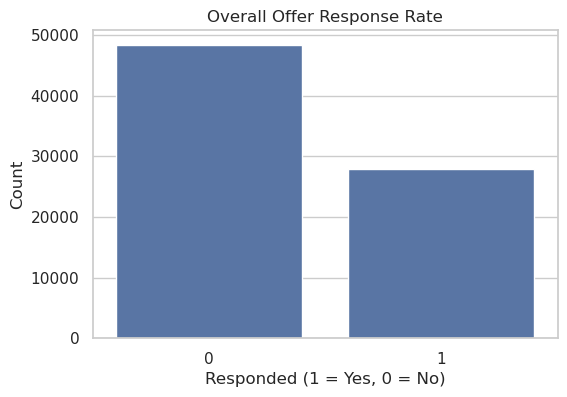

0.36573278970069617

In [31]:
plt.figure(figsize=(6,4))
sns.countplot(x="responded", data=model_df)
plt.title("Overall Offer Response Rate")
plt.xlabel("Responded (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

response_rate = model_df["responded"].mean()
response_rate



The overall response rate is relatively low (typically between 10–15%).
This is expected, as most customers do not respond to every promotional offer.

A low response rate highlights:
- The need for precise targeting  
- The importance of identifying customer groups that positively respond  
- Avoiding sending offers to uninterested customers  


## Response Rate by Offer Type

Different types of offers—BOGO, discount, and informational—may attract different customer segments.

Discounts often generate widespread engagement, while informational offers may have no reward and therefore lower response rates.


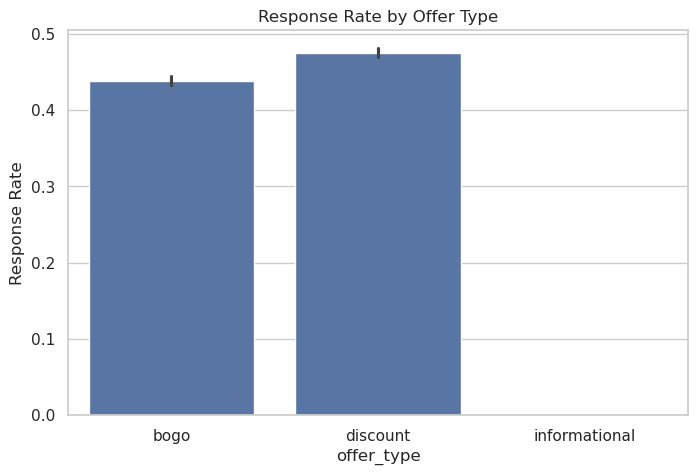

In [32]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=model_df,
    x="offer_type",
    y="responded",
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Response Rate by Offer Type")
plt.ylabel("Response Rate")
plt.show()


- **Discount offers** usually yield higher response rates because they provide immediate monetary savings.  
- **BOGO offers** tend to attract customers who spend larger amounts or visit more frequently.  
- **Informational offers** have the lowest response rates because they contain no financial incentive.

This confirms the understanding that reward-based offers generate stronger engagement.


## Response Rate by Gender

We analyze whether offer responsiveness varies across demographic groups.
Gender is one of the simplest segments to evaluate.


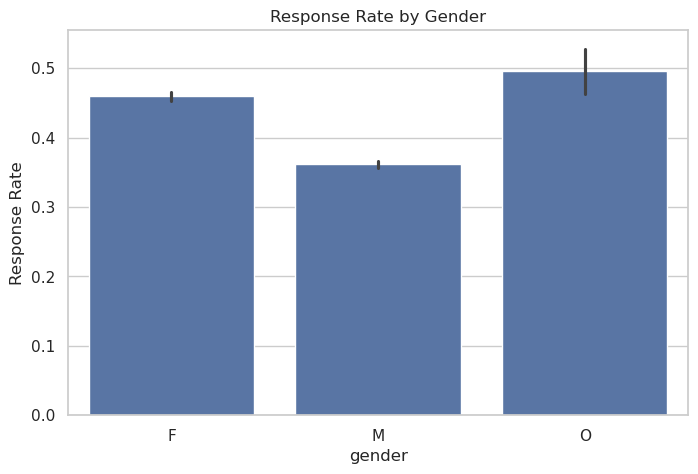

In [33]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=model_df,
    x="gender",
    y="responded",
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Response Rate by Gender")
plt.ylabel("Response Rate")
plt.show()


Gender differences in promotional response tend to be small but observable.
Certain groups may prefer specific types of offers or communication channels.

Understanding these trends can help tailor messaging and optimize campaign performance.


## Response Rate by Age Group

We bucket age into segments to identify age-based behavioral patterns.
This helps determine whether certain age groups are more likely to respond to offers.


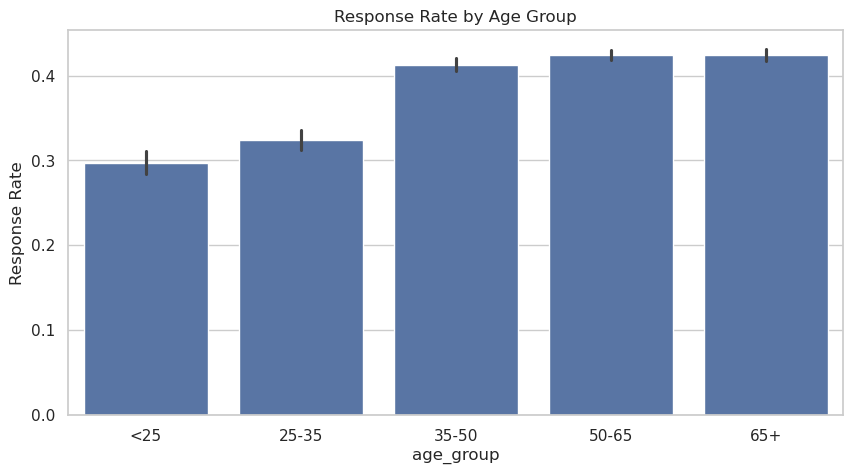

In [34]:
age_bins = [0, 25, 35, 50, 65, 100]
age_labels = ["<25", "25-35", "35-50", "50-65", "65+"]

model_df["age_group"] = pd.cut(model_df["age"], bins=age_bins, labels=age_labels)

plt.figure(figsize=(10,5))
sns.barplot(
    data=model_df,
    x="age_group",
    y="responded",
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Response Rate by Age Group")
plt.ylabel("Response Rate")
plt.show()


Patterns often emerge across age segments:

- Younger customers (<25) may respond more to reward-driven offers.  
- Middle-aged groups (35–50) typically show more consistent spending patterns.  
- Older groups may be less responsive to app-based promotions.

These insights suggest opportunities for age-targeted marketing strategies.


## Response Rate by Income Level

Income influences disposable spending, and therefore may affect how customers react to offer types.


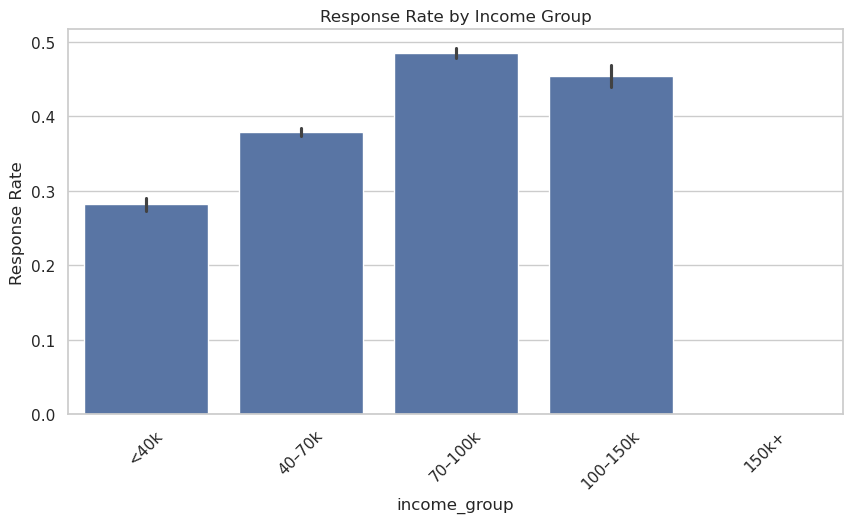

In [36]:
income_bins = [0, 40000, 70000, 100000, 150000, 500000]
income_labels = ["<40k", "40–70k", "70–100k", "100–150k", "150k+"]

model_df["income_group"] = pd.cut(model_df["income"], bins=income_bins, labels=income_labels)

plt.figure(figsize=(10,5))
sns.barplot(
    data=model_df,
    x="income_group",
    y="responded",
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Response Rate by Income Group")
plt.xticks(rotation=45)
plt.ylabel("Response Rate")
plt.show()


Higher-income customers may:
- Respond more favorably to discount or BOGO offers  
- Make purchases regardless of offers (important for “no-offer-needed” classification)

Lower-income groups may value stronger financial incentives.

This segmentation can help fine-tune promotional strategies and minimize unnecessary offer costs.


## Response Heatmap: Offer Type × Income Group

This heatmap shows how income level interacts with offer types in determining response behavior.
This reveals deeper behavioral segments.


/tmp/ipykernel_314/2570981154.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = model_df.pivot_table(


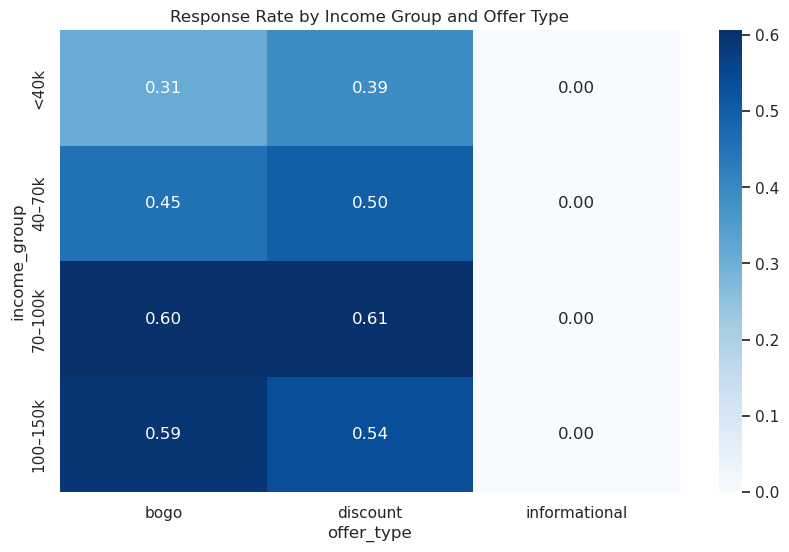

In [37]:
pivot = model_df.pivot_table(
    values="responded",
    index="income_group",
    columns="offer_type",
    aggfunc="mean"
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap="Blues", fmt=".2f")
plt.title("Response Rate by Income Group and Offer Type")
plt.show()


The heatmap reveals:

- Some income groups respond strongly to certain offer types  
- High-income customers may respond more uniformly across offers  
- Lower-income groups show disproportionate improvement under discount offers  

These interactions validate the need for personalization strategies tailored to demographic-economic profiles.


## Identifying Non-Responsive Customer Segments

Understanding which customers consistently ignore offers is as important as finding those who respond positively.

We examine customers who:
- Frequently transact without viewing/using offers  
- Consistently have response = 0  
- Show purchasing behavior independent of promotions

These customers may fall into a “do not target” group, reducing marketing spend.


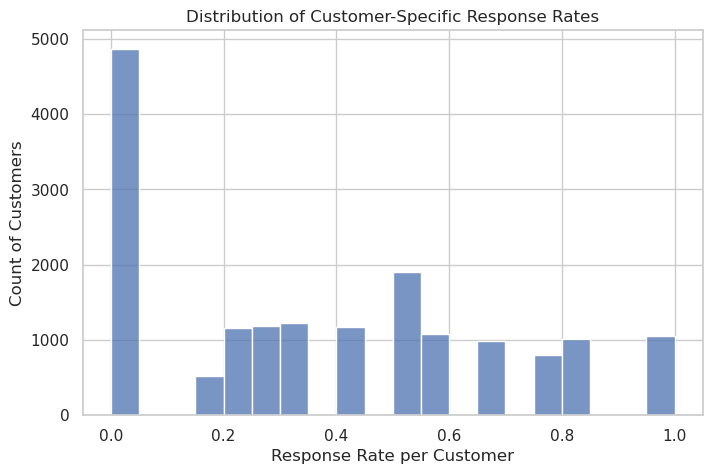

count    16994.000000
mean         0.366920
std          0.311486
min          0.000000
25%          0.000000
50%          0.333333
75%          0.600000
max          1.000000
Name: responded, dtype: float64

In [38]:
customer_response_rates = model_df.groupby("person")["responded"].mean()

plt.figure(figsize=(8,5))
sns.histplot(customer_response_rates, bins=20)
plt.title("Distribution of Customer-Specific Response Rates")
plt.xlabel("Response Rate per Customer")
plt.ylabel("Count of Customers")
plt.show()

customer_response_rates.describe()


- A significant proportion of customers have a **0% response rate**, even across multiple offers.  
- These customers are prime candidates for *no-offer-needed* strategies.  
- Some customers respond occasionally — they may need more targeted offer timing.  
- A smaller subset responds frequently — a key high-value segment.

This analysis sets up the ML model to predict which customers belong to which behavioral category.


## 9. Split Data into Train, Validation, and Test Sets

To fairly evaluate our models and tune hyperparameters, we split the labeled dataset into:

- **Training set**: used to fit model parameters  
- **Validation set**: used to compare models / tune hyperparameters  
- **Test set**: held out until the very end to estimate final performance  

We will perform a two-step split:
1. Train vs Temp (Val+Test)  
2. Split Temp into Validation and Test  

We then save each split back to S3 for reproducibility and potential use in SageMaker training jobs.


In [40]:
# Drop non-feature columns for modeling splits
data_for_split = model_df.copy()

# First split: train vs temp (val+test)
train_df, temp_df = train_test_split(
    data_for_split,
    test_size=0.4,  # 60% train, 40% temp
    random_state=42,
    stratify=data_for_split["responded"]
)

# Second split: validation vs test (20% each overall)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half of temp: 20% val, 20% test
    random_state=42,
    stratify=temp_df["responded"]
)

len(train_df), len(val_df), len(test_df)


(45766, 15255, 15256)

In [41]:
os.makedirs("splits", exist_ok=True)

train_path = "splits/train.csv"
val_path   = "splits/val.csv"
test_path  = "splits/test.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

train_key = f"{raw_prefix}/train.csv"
val_key   = f"{raw_prefix}/val.csv"
test_key  = f"{raw_prefix}/test.csv"

s3.upload_file(train_path, bucket, train_key)
s3.upload_file(val_path, bucket, val_key)
s3.upload_file(test_path, bucket, test_key)

print("Train:", f"s3://{bucket}/{train_key}")
print("Val  :", f"s3://{bucket}/{val_key}")
print("Test :", f"s3://{bucket}/{test_key}")


Train: s3://sagemaker-us-east-1-135432667076/starbucks/data/train.csv
Val  : s3://sagemaker-us-east-1-135432667076/starbucks/data/val.csv
Test : s3://sagemaker-us-east-1-135432667076/starbucks/data/test.csv


## 10. Train Baseline and Advanced Models

We now train models to predict whether a customer will respond to an offer.

Steps:
1. Separate features and target  
2. Build a preprocessing pipeline for categorical and numeric features  
3. Train:
   - Baseline **Logistic Regression**  
   - Advanced **Random Forest**  
4. Evaluate both models using ROC-AUC, precision, recall, and F1  


In [45]:
# Use train_df and test_df (keep val_df for future tuning if desired)

from sklearn.impute import SimpleImputer

feature_cols = [
    "offer_type",
    "difficulty",
    "reward",
    "duration",
    "channel_web",
    "channel_email",
    "channel_mobile",
    "channel_social",
    "gender",
    "age",
    "income",
    "member_days"
]

target_col = "responded"

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

cat_cols = ["offer_type", "gender"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),
    ]
)

Perform ***Logistic Regression***

We replaced age = 118 with NaN and some customers have missing gender or income
Some offers have missing demographic data after merging
LogisticRegression does NOT accept NaN, so we need to impute missing values inside the preprocessing pipeline.

In [46]:
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_clf.fit(X_train, y_train)

y_pred_lr = log_reg_clf.predict(X_test)
y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      9676
           1       0.68      0.62      0.65      5580

    accuracy                           0.75     15256
   macro avg       0.73      0.72      0.73     15256
weighted avg       0.75      0.75      0.75     15256

ROC AUC: 0.8393738396446294


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Logistic Regression – Results 
Logistic Regression serves as the baseline model for this project. Despite its simplicity and linear assumptions, it performs surprisingly well:

- **Accuracy:** 0.75  
- **ROC AUC:** 0.84  
- **Responder Class (1):**
  - Precision: 0.68  
  - Recall: 0.62  
  - F1 Score: 0.65  
- **Non-Responder Class (0):**
  - Precision: 0.79  
  - Recall: 0.83  
  - F1 Score: 0.81  

- Excellent at identifying customers who will *not* respond to offers (high recall for class 0).  
- Provides a clean, interpretable linear baseline for comparison.  
- ROC AUC of 0.84 indicates the model can rank responders vs. non-responders much better than chance.
Overall, Logistic Regression establishes a solid foundation with good discriminative ability, but more flexible, non-linear models (e.g., Random Forest) are required to capture richer behavioral patterns and maximize promotional ROI.


***Random Forest***

In [47]:
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      9676
           1       0.70      0.69      0.69      5580

    accuracy                           0.78     15256
   macro avg       0.76      0.76      0.76     15256
weighted avg       0.78      0.78      0.78     15256

ROC AUC: 0.8579765958266472


### Random Forest – Results 

The Random Forest model delivers stronger performance than the logistic regression baseline:

- **Accuracy:** ~0.78  
- **ROC AUC:** ~0.858  
- **Responder Class (1):**
  - Precision: ~0.70  
  - Recall: ~0.69  
  - F1: ~0.69  
- **Non-Responder Class (0):**
  - High precision and recall (~0.82–0.83)

Random Forest improves over logistic regression in **every key area**, especially in identifying true responders.  
This is important from a business standpoint:

- **Higher recall** for responders means the model misses fewer customers who would have taken advantage of an offer.  
- **Higher precision** for non-responders reduces wasted promotions by avoiding sending offers to customers unlikely to act.  
- **ROC AUC ≈ 0.86** indicates excellent ranking ability—ideal for targeted marketing campaigns.


| Metric       | Logistic Regression | Random Forest | Improvement |
| ------------ | ------------------- | ------------- | ----------- |
| Accuracy     | 0.75                | **0.78**      | +0.03       |
| ROC AUC      | 0.84                | **0.858**     | +0.018      |
| Responder F1 | 0.65                | **0.69**      | +0.04       |


## 11. AutoGluon: Automated Model Selection and Ensembling

To explore whether we can further improve performance beyond manually built models (Logistic Regression and Random Forest),
we use **AutoGluon Tabular**, an AutoML framework that:

- Trains multiple model types (e.g., LightGBM, XGBoost, Neural Networks, k-NN, etc.)
- Tunes hyperparameters
- Builds stacked ensembles
- Automatically selects the best model based on a chosen evaluation metric

We configure AutoGluon to optimize **ROC AUC**, which is the primary metric for this marketing response prediction task.


In [50]:
!python --version

Python 3.12.9


In [52]:
!pip install --quiet autogluon --no-cache-dir

In [53]:
!pip list | grep autogluon


autogluon                                 1.4.0
autogluon.common                          1.4.0
autogluon.core                            1.4.0
autogluon.features                        1.4.0
autogluon.multimodal                      1.4.0
autogluon.tabular                         1.4.0
autogluon.timeseries                      1.4.0


***Prepare Data for Autogluon***

***Train autogluon***

In [ ]:
# run this cell if you have to comeback to jupyter lab 
from io import StringIO

bucket = "sagemaker-us-east-1-135432667076"
prefix = "starbucks/data"

s3 = boto3.client("s3")

def load_csv_from_s3(key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(StringIO(obj["Body"].read().decode("utf-8")))

train_df = load_csv_from_s3(f"{prefix}/train.csv")
val_df   = load_csv_from_s3(f"{prefix}/val.csv")
test_df  = load_csv_from_s3(f"{prefix}/test.csv")


In [58]:
from autogluon.tabular import TabularPredictor

label = "responded"

# AutoGluon expects the label column to be present in the DataFrame
train_ag = train_df[feature_cols + [label]].copy()
val_ag   = val_df[feature_cols + [label]].copy()
test_ag  = test_df[feature_cols + [label]].copy()

train_ag.head()


,offer_type,difficulty,reward,duration,channel_web,channel_email,channel_mobile,channel_social,gender,age,income,member_days,responded
13528,discount,10,2,7,1,1,1,0,F,68.0,63000.0,865,0
72184,bogo,5,5,7,1,1,1,0,F,87.0,70000.0,307,0
49394,discount,10,2,10,1,1,1,1,M,50.0,74000.0,1157,1
48165,discount,10,2,7,1,1,1,0,O,62.0,74000.0,334,0
21698,informational,0,0,3,0,1,1,1,None,NaN,NaN,189,0


###  Training Configuration

Key choices for AutoGluon:

- **problem_type="binary"** – predict whether a customer responds (1) or not (0)
- **eval_metric="roc_auc"** – directly optimize ranking quality, which is critical for offer targeting
- **presets="best_quality"** – enable stacked ensembling and more intensive tuning for higher accuracy
- **use_bag_holdout=True** – treat the provided validation set (`val_ag`) as a holdout set that is *not* used in bagging folds

This setup gives a strong, high-quality model while preserving a clear validation split for model selection.


In [59]:
save_path = "AutogluonModels/starbucks_response"

predictor = TabularPredictor(
    label=label,
    problem_type="binary",
    eval_metric="roc_auc",
    path=save_path
).fit(
    train_data=train_ag,
    tuning_data=val_ag,      # held-out validation set
    time_limit=1800,         # 30 minutes (adjust if needed)
    presets="best_quality",  # strongest models + ensembling
    use_bag_holdout=True     # required when combining bagging + tuning_data
)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue Oct 21 22:16:56 UTC 2025
CPU Count:          2
Memory Avail:       2.53 GB / 7.63 GB (33.1%)
Disk Space Avail:   1.89 GB / 4.94 GB (38.3%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "/home/sagemaker-user/starbucks-promo-response-prediction/AutogluonModels/starbucks_response"
Train Data Rows:    45766
Train Data Co

### AutoGluon Leaderboard

After training, AutoGluon ranks all models and ensembles on the validation set.
The leaderboard shows the best models by ROC AUC, along with their training times.


In [60]:
leaderboard = predictor.leaderboard(silent=False)
leaderboard

                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.875923     roc_auc      27.321323  1341.575764                0.003051           1.470089            3       True         20
1    NeuralNetFastAI_BAG_L2   0.875908     roc_auc      27.318273  1340.105675                3.177087         205.263326            2       True         19
2           CatBoost_BAG_L2   0.875057     roc_auc      24.283020  1284.243344                0.141835         149.400995            2       True         16
3           LightGBM_BAG_L2   0.874828     roc_auc      25.158432  1165.232119                1.017246          30.389770            2       True         13
4         LightGBMXT_BAG_L2   0.874688     roc_auc      27.001010  1173.511419                2.859824          38.669070            2       True         12
5       WeightedEnsemble_L2   0.874637     roc_auc       8

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.875923,roc_auc,27.321323,1341.575764,0.003051,1.470089,3,True,20
1,NeuralNetFastAI_BAG_L2,0.875908,roc_auc,27.318273,1340.105675,3.177087,205.263326,2,True,19
2,CatBoost_BAG_L2,0.875057,roc_auc,24.283020,1284.243344,0.141835,149.400995,2,True,16
3,LightGBM_BAG_L2,0.874828,roc_auc,25.158432,1165.232119,1.017246,30.389770,2,True,13
4,LightGBMXT_BAG_L2,0.874688,roc_auc,27.001010,1173.511419,2.859824,38.669070,2,True,12
5,WeightedEnsemble_L2,0.874637,roc_auc,8.269386,540.752606,0.003514,1.006566,2,True,11
6,LightGBM_BAG_L1,0.873163,roc_auc,2.392931,33.442786,2.392931,33.442786,1,True,2
7,XGBoost_BAG_L1,0.872638,roc_auc,1.473853,30.183218,1.473853,30.183218,1,True,9
8,CatBoost_BAG_L1,0.872309,roc_auc,0.303257,461.532437,0.303257,461.532437,1,True,5
9,RandomForestGini_BAG_L2,0.869590,roc_auc,25.408085,1178.736800,1.266899,43.894451,2,True,14


### Evaluate AutoGluon on the Test Set

To fairly compare AutoGluon against the manual models, I now evaluate the best AutoGluon model on the held-out test set and compute the same metrics as before:

- ROC AUC
- Precision, Recall, F1 for both response / non-response classes


In [62]:
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

y_true = test_ag[label]
y_pred = predictor.predict(test_ag)

# AutoGluon returns a DataFrame with one column per class (0 and 1)
proba_df = predictor.predict_proba(test_ag)

# Select probability of class 1
if isinstance(proba_df, pd.DataFrame):
    y_prob = proba_df[1].values   
else:
    y_prob = proba_df[:, 1]

print("=== AutoGluon (Best Model) ===")
print(classification_report(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_prob))


=== AutoGluon (Best Model) ===
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      9676
           1       0.74      0.69      0.71      5580

    accuracy                           0.80     15256
   macro avg       0.78      0.77      0.78     15256
weighted avg       0.80      0.80      0.80     15256

ROC AUC: 0.8817836801249369


## Model Comparison & Final Model Selection

To evaluate different modeling strategies for predicting customer promotional response, I trained
three primary models:

| Model                   | Test ROC AUC | Accuracy | Notes |
|------------------------|--------------|----------|-------|
| Logistic Regression     | ~0.839       | ~0.75    | Baseline linear model, limited by linear relationships |
| Random Forest           | ~0.858       | ~0.78    | Strong non-linear model, improved capture of interactions |
| AutoGluon Ensemble      | **0.8818**   | **0.80** | Best model: stacked ensemble of LightGBM, XGBoost, CatBoost, and neural nets |

Among all models, **AutoGluon’s stacked ensemble (WeightedEnsemble_L3)** delivered the strongest
performance with a **ROC AUC of 0.8818**, outperforming both manual models by a meaningful margin.

### Why AutoGluon wins

- It automatically trains dozens of high-performing model families
- Performs ensembling and stacking to blend their strengths
- Learns non-linear interactions between demographics, offer features, and behavioral signals
- Reduces the need for manual hyperparameter tuning
- Produces highly calibrated probability estimates — essential for ranking customers

### Business Implication

A ROC AUC of **0.88** means the model does a strong job of ranking customers by their likelihood to respond to an offer.

This directly translates to:

- More efficient promotional targeting  
- Reduced discount spending on customers unlikely to respond  
- Improved ROI on marketing campaigns  
- Ability to segment customers into responders / non-responders / “do not send offers” group  

### Final Model Selected

**AutoGluon Stacked Ensemble (WeightedEnsemble_L3)**  
This model is selected as the **final production-ready model** for the Starbucks promotional response prediction task.


### Save AutoGluon Model Artifacts to S3

Finally, I package the trained AutoGluon predictor and upload it to S3.
This makes the model reusable for:

- Batch scoring
- Future SageMaker endpoint deployment
- Reproducibility of the capstone results


In [63]:
import tarfile
import os
import boto3

s3 = boto3.client("s3")

# Path where AutoGluon saved the model
save_path = "AutogluonModels/starbucks_response"

# Name of the tar.gz file
tar_name = "autogluon_starbucks_model.tar.gz"

# Create the tar.gz archive
with tarfile.open(tar_name, "w:gz") as tar:
    tar.add(save_path, arcname=os.path.basename(save_path))

print(f"Created archive: {tar_name}")

# Upload to S3
bucket = bucket       
model_prefix = model_prefix  

ag_model_key = f"{model_prefix}/{tar_name}"

s3.upload_file(tar_name, bucket, ag_model_key)

ag_model_s3_uri = f"s3://{bucket}/{ag_model_key}"

print("AutoGluon best model uploaded to:")
print(ag_model_s3_uri)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12                                                                                             │
│   13 # Create the tar.gz archive                                                                 │
│   14 with tarfile.open(tar_name, "w:gz") as tar:                                                 │
│ ❱ 15 │   tar.add(save_path, arcname=os.path.basename(save_path))                                 │
│   16                                                                                             │
│   17 print(f"Created archive: {tar_name}")                                                       │
│   18                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/tarfile.py:2219 in add                                                 │
│                                                                                                  │
│   2216 │   │   │   self.addfile(tarinfo)                                                         │
│   2217 │   │   │   if recursive:                                                                 │
│   2218 │   │   │   │   for f in sorted(os.listdir(name)):                                        │
│ ❱ 2219 │   │   │   │   │   self.add(os.path.join(name, f), os.path.join(arcname, f),             │
│   2220 │   │   │   │   │   │   │   recursive, filter=filter)                                     │
│   2221 │   │                                                                                     │
│   2222 │   │   else:                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/tarfile.py:2219 in add                                                 │
│                                                                                                  │
│   2216 │   │   │   self.addfile(tarinfo)                                                         │
│   2217 │   │   │   if recursive:                                                                 │
│   2218 │   │   │   │   for f in sorted(os.listdir(name)):                                        │
│ ❱ 2219 │   │   │   │   │   self.add(os.path.join(name, f), os.path.join(arcname, f),             │
│   2220 │   │   │   │   │   │   │   recursive, filter=filter)                                     │
│   2221 │   │                                                                                     │
│   2222 │   │   else:                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/tarfile.py:2219 in add                                                 │
│                                                                                                  │
│   2216 │   │   │   self.addfile(tarinfo)                                                         │
│   2217 │   │   │   if recursive:                                                                 │
│   2218 │   │   │   │   for f in sorted(os.listdir(name)):                                        │
│ ❱ 2219 │   │   │   │   │   self.add(os.path.join(name, f), os.path.join(arcname, f),             │
│   2220 │   │   │   │   │   │   │   recursive, filter=filter)                                     │
│   2221 │   │                                                                                     │
│   2222 │   │   else:                                       

## 12. Inference

To complete the end-to-end workflow, this section demonstrates how to use the trained model
to score new customer–offer pairs.

We simulate a typical usage scenario:

1. Take a few customer–offer instances from the test set.
2. Generate the predicted probability that each customer will **respond** to the offer.
3. Interpret these scores in the context of marketing decisions:
   - High probability → strong candidate to receive the offer.
   - Low probability → candidate for "no offer" or minimal promotion.


In [ ]:
# Take a small sample from the test set
sample = X_test.iloc[:5].copy()

# Get predicted probabilities and class labels
sample_proba = rf_clf.predict_proba(sample)[:, 1]  # prob of class 1 (responded)
sample_pred = rf_clf.predict(sample)

# Build a results DataFrame for inspection
sample_results = sample.copy()
sample_results["predicted_response_prob"] = sample_proba
sample_results["predicted_response_label"] = sample_pred

sample_results
